In [1]:
import os
from pathlib import Path
import numpy as np
import xarray as xa
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib.dates as mdates
from pylibs.plot_utils import set_size
from pylibs.utils import get_dates
from tqdm import tqdm
from joblib import Parallel, delayed
from datetime import datetime, timedelta
import seaborn as sns

In [2]:
tlsize = 12
txsize = 12
mpl.rc('axes', titlesize=tlsize, labelsize=txsize)
mpl.rc('xtick', labelsize=txsize)
mpl.rc('ytick', labelsize=txsize)
mpl.rc('legend', fontsize='small')
minussign=u'\u2212'

In [3]:
axe_w = 8; axe_h = 3; plot_quality = 600
# Level control
vmin = 0; vmax = 1.e-4
# Colorbar control
cb_ori = 'vertical'
cb_frac = 0.025
cb_pad = 0.04
cb_asp = 32
# Area control
area = 'wxaq'
minlon = -81.; maxlon = -70; minlat = 39.8; maxlat = 46.
plotqc = -1

srcpath = '/glade/work/swei/Git/JEDI-METplus'

plot_product = 'wrfchem_evaluate'
obs_name_list = [
    'tropomi_s5p_no2_troposphere-wxaq',
    'tempo_no2_tropo-wxaq',
]
obsname_dict = {
    'tropomi_s5p_no2_troposphere-wxaq': 'TROPOMI',
    'tempo_no2_tropo-wxaq': 'TEMPO',
}

# JEDI variable name, var:channel 
plot_var = 'nitrogendioxideColumn'

vrfy_init = '00'
vrfy_day = 1
sdate = 2024082201
edate = 2024090100
hint = 1
dates = get_dates(sdate, edate, hint)

unit_str = 'mol m$^{-2}$'
ylbstr = '%s (%s)' % (plot_var, unit_str)

hofx_path = os.path.join(srcpath, 'output', plot_product, 'hofx')
plts_path = os.path.join(srcpath, 'output', plot_product, 'plots', 'timeseries')

if not os.path.exists(hofx_path):
    raise Exception(f'HofX folder: {hofx_path} is not available')

if not os.path.exists(plts_path):
    os.makedirs(plts_path)

In [4]:
def get_fhr(cdate, vrfy_init, vrfy_day):
    if int(vrfy_init) >= int(cdate.strftime('%H')):
        fhr = (vrfy_day) * 24 - abs(int(vrfy_init) - int(cdate.strftime('%H')))
    else:
        fhr = (vrfy_day-1) * 24 - (int(vrfy_init) - int(cdate.strftime('%H')))
    return f'{fhr:02d}'

In [6]:
def process_dates_bias_rmse(cdate, obsname, varname, vrfy_init, vrfy_day):

    tmpdf = pd.DataFrame()
    tmpdf['obsname'] = [obsname]
    tmpdf['datetime'] = [cdate]

    cdate_str = cdate.strftime('%Y%m%d%H')
    fhr_str = get_fhr(cdate, vrfy_init, vrfy_day)
    hofxfile = f'{hofx_path}/f{fhr_str}/{obsname}/hofx.{obsname}.{cdate_str}.nc4'
    if not os.path.exists(hofxfile):
        tmpdf['bias'] = [np.nan]
        tmpdf['rmse'] = [np.nan]
    else:
        # metads = xa.open_dataset(hofxfile, group='MetaData')
        obsvds = xa.open_dataset(hofxfile, group='ObsValue')
        hofxds = xa.open_dataset(hofxfile, group='hofx')

        bias = np.nanmean(hofxds[varname].values - obsvds[varname].values)
        rmse = np.sqrt(np.nanmean(np.square(hofxds[varname].values - obsvds[varname].values)))
        tmpdf['bias'] = [bias]
        tmpdf['rmse'] = [rmse]

    return tmpdf

In [10]:
all_df = pd.DataFrame()
for obs in obs_name_list:
    print(f'Processing {obs}')
    results = Parallel(n_jobs=-1)(
        delayed(process_dates_bias_rmse)(
            cdate, obs, plot_var, vrfy_init, vrfy_day) for cdate in tqdm(dates))
    obs_df = pd.concat(results, ignore_index=True)
    all_df = pd.concat((all_df, obs_df), ignore_index=True)
all_df['localtime'] = all_df['datetime'].dt.tz_localize('UTC').dt.tz_convert('America/New_York')
print('Process Finished')

Processing tropomi_s5p_no2_troposphere-wxaq


100%|██████████| 240/240 [00:00<00:00, 476.59it/s]
/glade/derecho/scratch/swei/tmp/ipykernel_35178/2515698324.py:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  obs_df = pd.concat(results, ignore_index=True)


Processing tempo_no2_tropo-wxaq


100%|██████████| 240/240 [00:01<00:00, 125.22it/s]

Process Finished



/glade/derecho/scratch/swei/tmp/ipykernel_35178/2515698324.py:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  obs_df = pd.concat(results, ignore_index=True)


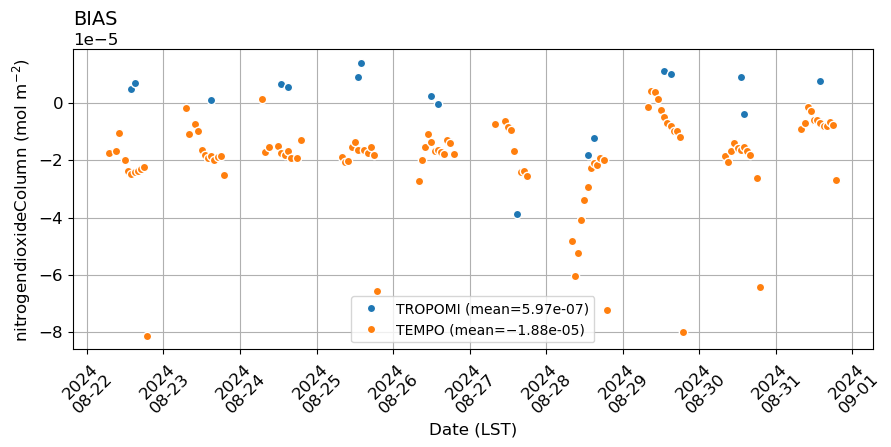

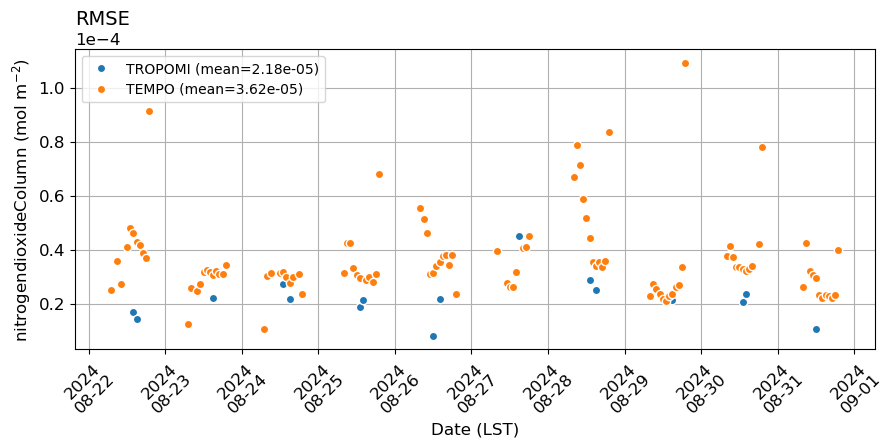

In [11]:
for stattype in ['bias', 'rmse']:
    fig, ax = plt.subplots()
    set_size(axe_w, axe_h, b=0.25, l=0.1, r=0.95, t=0.9)
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
    shortobsname_list = []
    for obs in all_df['obsname'].unique():
        subset = all_df[all_df['obsname'] == obs]
        mean = subset[stattype].mean()
        if mean < 0: 
            mean_str = f'{minussign}{abs(mean):.2e}' 
        else:
            mean_str = f'{mean:.2e}'
        shortobsname_list.append(obsname_dict[obs])
        label = f"{obsname_dict[obs]} (mean={mean_str})"
        ax.plot(subset['localtime'], subset[stattype], marker='o', linestyle=' ', label=label, mec='w')
        
    filename_obstag = "_".join(shortobsname_list)    
    date_format = mdates.DateFormatter('%Y\n%m-%d')  # Customize this
    plt.gca().xaxis.set_major_formatter(date_format)
    plt.xticks(rotation=45)
    plt.title(stattype.upper(), loc='left', fontsize=txsize+2)
    plt.xlabel("Date (LST)")
    plt.ylabel(ylbstr)
    plt.grid(True)
    plt.legend(fontsize=txsize-2)
    outname = f'{plts_path}/{stattype}.{filename_obstag}.{sdate}_{edate}.png'
    fig.savefig(outname, dpi=plot_quality)

In [144]:
outname

'/glade/work/swei/Git/JEDI-METplus/output/wrfchem_evaluate/plots/timeseries/rmse.TROPOMI_TEMPO.2024082201_2024090100.png'